In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *

# Positive Relationship

In [2]:
J = 5
d =5000
#sigma = np.repeat(1,J)
K=0.8
psi1 = K * np.eye(J)
sigma = 1.0 / np.arange(1, J + 1)
X_coef, F_basis, fd_basis = generate_far2_coef(d, J, Sigma=sigma, Psi1=psi1, Psi2=None, seed=10)
print(X_coef.shape)

norms of the basis are: [1. 1. 1. 1. 1.]
(5000, 5)


# Compute the true Long run covariance matrix on the Fourier Basis

In [3]:
center_dat_tensor = torch.tensor(X_coef, dtype=torch.float32)
center_dat_tensor.shape

torch.Size([5000, 5])

In [4]:
cov_weighted_true,_,_ =cov_l(center_dat_tensor , 0, round(d**(1/2)),  "Bartlett")
print((cov_weighted_true * 100).round() / 100)
sum(np.diag(cov_weighted_true))

tensor([[27.4800, -0.0800, -1.0400,  0.3800, -0.7400],
        [-0.0800,  7.4200,  0.8700,  0.0900, -0.3500],
        [-1.0400,  0.8700,  2.3800, -0.2200,  0.0500],
        [ 0.3800,  0.0900, -0.2200,  1.7300, -0.0500],
        [-0.7400, -0.3500,  0.0500, -0.0500,  0.7800]])


np.float32(39.780735)

# Conduct FPCA

In [5]:
print("NaNs in coef:", np.isnan(X_coef).any())
print("Infs in coef:", np.isinf(X_coef).any())
print("Max abs coef:", np.abs(X_coef).max())

NaNs in coef: False
Infs in coef: False
Max abs coef: 6.107822642606912


In [6]:
# Conduct FPCA
fpca_fbasis = FPCA(n_components=3)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.68587386 0.16978191 0.07480035]
0.930456116120531


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [7]:
E_coef = fpca_fbasis.components_.coefficients 
print(E_coef)
E_coef.shape

[[ 9.99787951e-01  8.05605811e-03 -1.87647830e-02  2.28307270e-04
  -2.64284998e-03]
 [-7.70930903e-03  9.99571259e-01  2.07026688e-02 -8.53602736e-03
  -1.72162805e-02]
 [ 1.89970846e-02 -1.97653202e-02  9.98810770e-01  1.79196234e-02
   3.61161512e-02]]


(3, 5)

In [8]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [9]:
Y_np.shape

(5000,)

In [10]:
scores.shape

(5000, 3)

In [11]:
center_dat = scores
center_dat.shape

(5000, 3)

In [12]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(d, 1)
print(Y.size())

torch.Size([5000, 3])
torch.Size([5000, 1])


# Model adding covariates

In [13]:
# Parameters
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)

17


In [14]:
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
cov_weighted

tensor([[21.1661, -0.0662, -0.4214],
        [-0.0662,  5.1804,  0.1259],
        [-0.4214,  0.1259,  2.0268]])

In [15]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))
print("The true LR covariance matrix is:")
print(np.round(cov_weighted_true.detach().numpy(),4))
print("The trace of the true LR covariance matrix is:")
print(sum(np.diag(cov_weighted_true)))

The estimated LR covariance matrix is:
[[ 2.11431e+01  7.43000e-02 -7.82500e-01 -1.20000e-03 -6.80000e-02]
 [ 7.43000e-02  5.17230e+00  1.87300e-01 -4.27000e-02 -8.64000e-02]
 [-7.82500e-01  1.87300e-01  2.05270e+00  3.43000e-02  7.16000e-02]
 [-1.20000e-03 -4.27000e-02  3.43000e-02  1.00000e-03  2.00000e-03]
 [-6.80000e-02 -8.64000e-02  7.16000e-02  2.00000e-03  4.20000e-03]]
The trace of the estimated LR covariance matrix is:
28.37333035469055
The true LR covariance matrix is:
[[27.48   -0.0777 -1.0416  0.3787 -0.736 ]
 [-0.0777  7.419   0.8669  0.0919 -0.351 ]
 [-1.0416  0.8669  2.378  -0.2196  0.0516]
 [ 0.3787  0.0919 -0.2196  1.7265 -0.0541]
 [-0.736  -0.351   0.0516 -0.0541  0.7772]]
The trace of the true LR covariance matrix is:
39.780735


Epoch [200/5000], Loss: 1.0688
Epoch [400/5000], Loss: 0.5167
Epoch [600/5000], Loss: 0.0998
Epoch [800/5000], Loss: 0.0115
Epoch [1000/5000], Loss: 0.0012
Epoch [1200/5000], Loss: 0.0001
Stopping early at Epoch [1218/5000], Loss: 0.000099

Restoring best model weights...


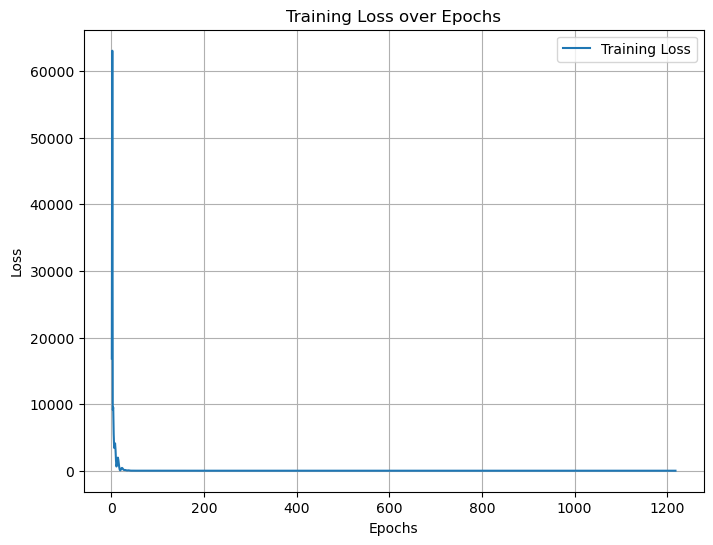

In [16]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (3, 3)


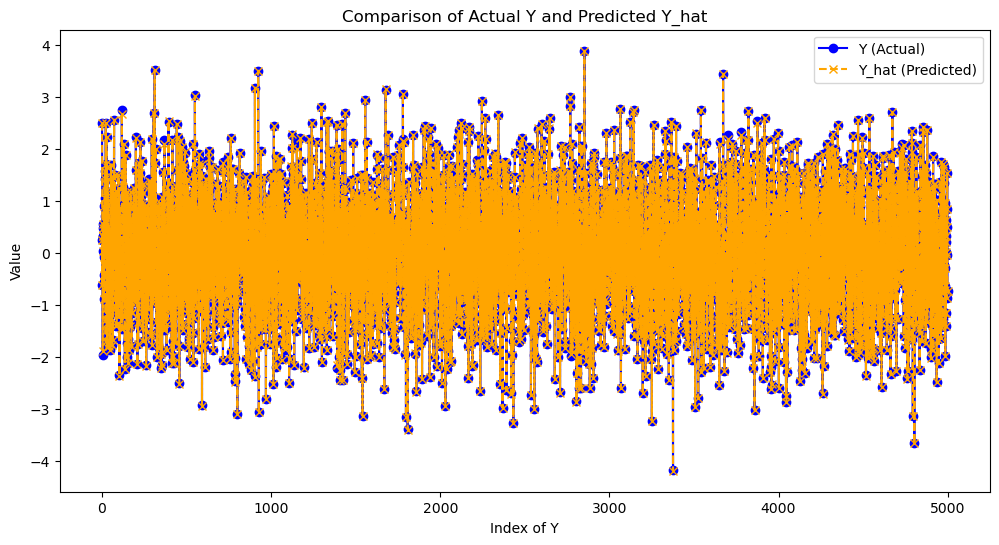

In [17]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


# Compute true covariance matrix

# Get the estimate CI for the mean function

In [18]:
# 1. Estimate the mean coefficient vector
X_coef_mean = X_coef.mean(axis=0)  # shape: (n_basis,)

# 2. Evaluate Fourier basis on a fine grid
u_grid = np.linspace(0, 1, 200)
phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)

# 3. Compute the mean function: sum_j mean_coef_j * phi_j(u)
mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)

# 4. Compute pointwise variance using the long-run covariance matrix
n = X_coef.shape[0]
var_curve = np.einsum('ij,jk,ik->i', phi_u.T, cov_weighted_transform / n, phi_u.T)

# 5. Construct 95% pointwise confidence intervals
z = 1.96
upper_band = mean_curve + z * np.sqrt(var_curve)
lower_band = mean_curve - z * np.sqrt(var_curve)


/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_15945/3382184743.py:6: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)


In [19]:
X_coef_mean

array([-1.09356968e-16, -6.92779167e-18,  4.93827201e-17, -5.42031697e-17,
       -3.56437102e-17])

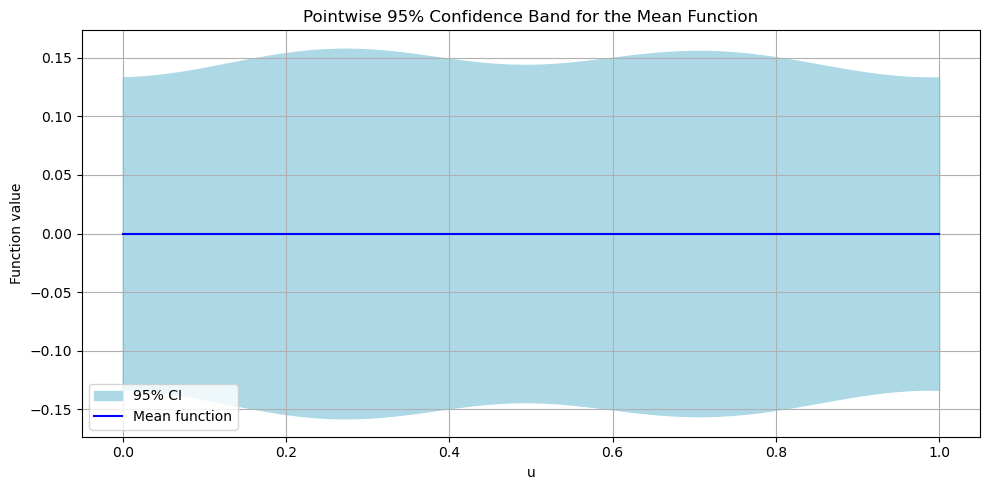

In [20]:
plt.figure(figsize=(10, 5))

# Plot the 95% confidence band as a shaded region
plt.fill_between(u_grid, lower_band, upper_band, color='lightblue', label='95% CI')

# Plot the mean function
plt.plot(u_grid, mean_curve, color='blue', label='Mean function')

# Axis labels and legend
plt.xlabel("u")
plt.ylabel("Function value")
plt.title("Pointwise 95% Confidence Band for the Mean Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Save the current mean and CI for K = 0.5
mean_curve_05 = mean_curve
upper_band_05 = upper_band
lower_band_05 = lower_band

In [22]:
# ======== Now repeat for K = -0.5 =========

psi1 = -K * np.eye(J)
X_coef_neg, F_basis, fd_basis = generate_far2_coef(d, J, Sigma=sigma, Psi1=psi1, Psi2=None, seed=10)
center_dat_tensor = torch.tensor(X_coef_neg, dtype=torch.float32)
cov_weighted_true, _, _ = cov_l(center_dat_tensor, 0, round(d ** (1 / 2)), "Bartlett")

# FPCA (re-fit)
fpca_fbasis = FPCA(n_components=3)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)
E_coef = fpca_fbasis.components_.coefficients

# Recompute LR covariance
center_dat = scores
X = torch.tensor(center_dat, dtype=torch.float32)
cov_weighted, _, _ = cov_l(X, porder, band, kern_type="Bartlett")
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef

# Evaluate basis and estimate CI again
X_coef_mean = X_coef_neg.mean(axis=0)
phi_u = F_basis.evaluate(u_grid)[:, :, 0]
mean_curve = phi_u.T @ X_coef_mean
n = X_coef_neg.shape[0]
var_curve = np.einsum('ij,jk,ik->i', phi_u.T, cov_weighted_transform / n, phi_u.T)
upper_band = mean_curve + z * np.sqrt(var_curve)
lower_band = mean_curve - z * np.sqrt(var_curve)

# Save K = -0.5 version
mean_curve_m05 = mean_curve
upper_band_m05 = upper_band
lower_band_m05 = lower_band

norms of the basis are: [1. 1. 1. 1. 1.]


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

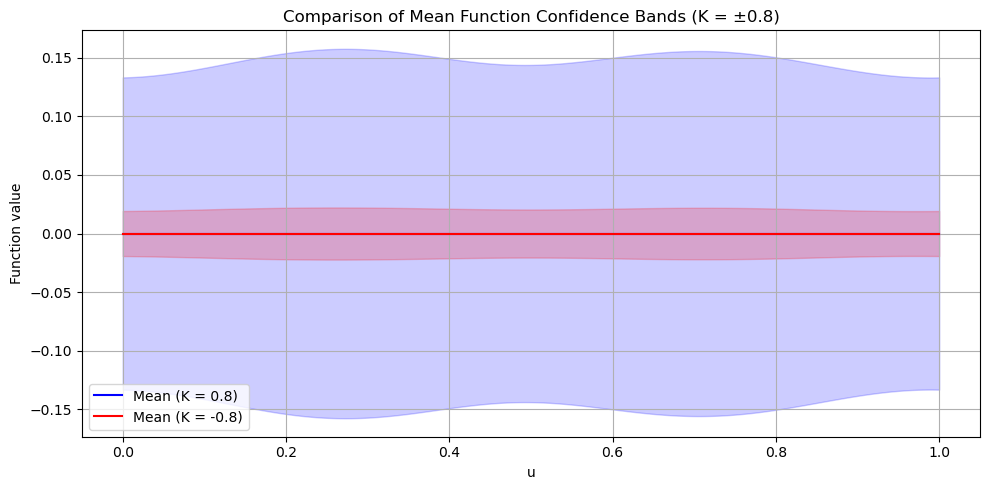

In [25]:
# ========== Plot comparison ==========
plt.figure(figsize=(10, 5))
plt.plot(u_grid, mean_curve_05, label='Mean (K = 0.8)', color='blue')
plt.fill_between(u_grid, lower_band_05, upper_band_05, color='blue', alpha=0.2)

plt.plot(u_grid, mean_curve_m05, label='Mean (K = -0.8)', color='red')
plt.fill_between(u_grid, lower_band_m05, upper_band_m05, color='red', alpha=0.2)

plt.xlabel("u")
plt.ylabel("Function value")
plt.title("Comparison of Mean Function Confidence Bands (K = ±0.8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"CIs/ar1_K_{K:.1f}.png", dpi=300, bbox_inches="tight")
plt.show()
